# Engineering Modeling and Design Optimization

This section demonstrates the use of surrogate-based design methods in solving problems that closely resemble those that are encountered in engineering. Such problems may include data that contains noise since not all processes encountered in engineering are deterministic. These problems may also include design variables that could have different scales that may make it difficult to apply surrogate modelling methods. The code blocks in this section will demonstrate how to apply surrogate modelling and design techniques in these situations.  

In [1]:
import numpy as np
from smt.surrogate_models import KRG, RBF
from smt.problems import TorsionVibration
from smt.sampling_methods import LHS, FullFactorial
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import norm
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.optimize import minimize
from pymoo.config import Config
Config.warnings['not_compiled'] = False

## Modeling a noisy function using regression Kriging

Often times, the data that is collected to model a function may be noisy. This noise could be due to the data being collected from an experiment and there is some randomness in the outcome of the experiment. In the code block below, the noisy version of the Forrester function is defined. This function is the Forrester function plus a simulated standard Gaussian noise term that is added to the function values. In this case, the function can be written as

$$f(\textbf{x})=(6x-2)^2 \sin(12x-4)+\epsilon$$
$$\epsilon \sim \mathcal{N}(0,1)$$

The block of code below defines the noisy Forrester function. 

In [2]:
# Defining the noisy forrester function
forrester = lambda x: (6*x - 2)**2*np.sin(12*x-4)  + norm.rvs(scale = 1.0, size=x.shape)

The block of code below generates training and testing data for the noisy forrester function. A Kriging model is created and fitted to the training data to make predictions for the noisy Forrester function. The number of samples in the training data are varied and plots are created to visualize the training data, predicted function values, true function values and the 95% confidence interval of the prediction.

In this case, the argument eval_noise is set to True while creating the Kriging model. This allows the model to account for the noise present in the data and fit a regression Kriging model that best fits the trend contained within the noisy data. This is in contrast with the regular Kriging model which is an interpolating model and passes through the training data points. 

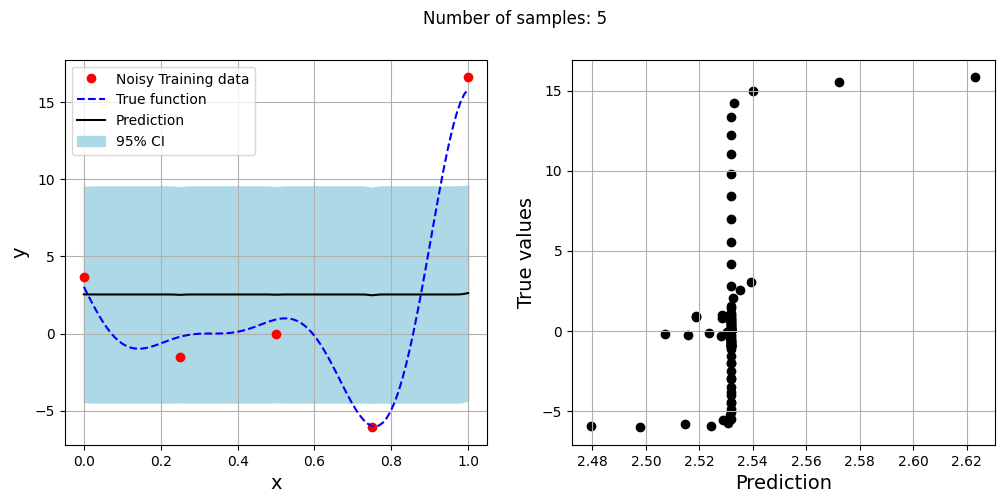

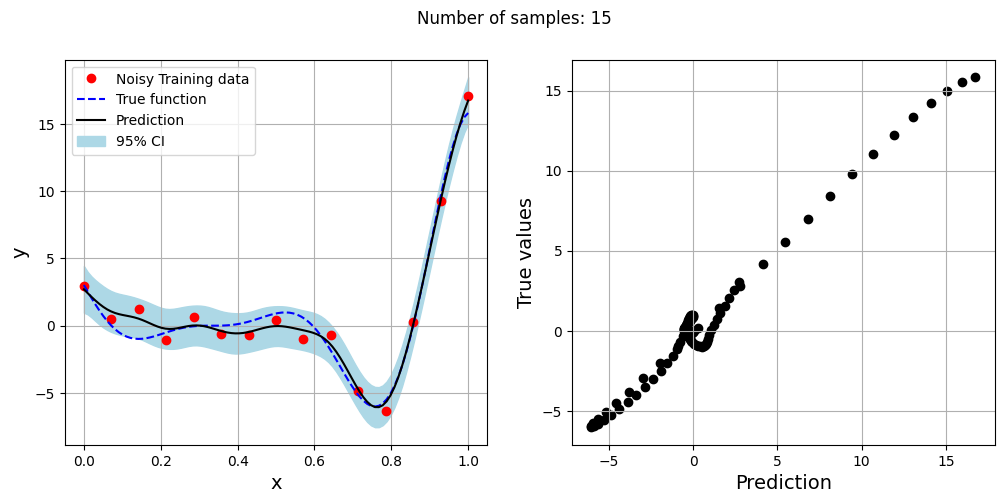

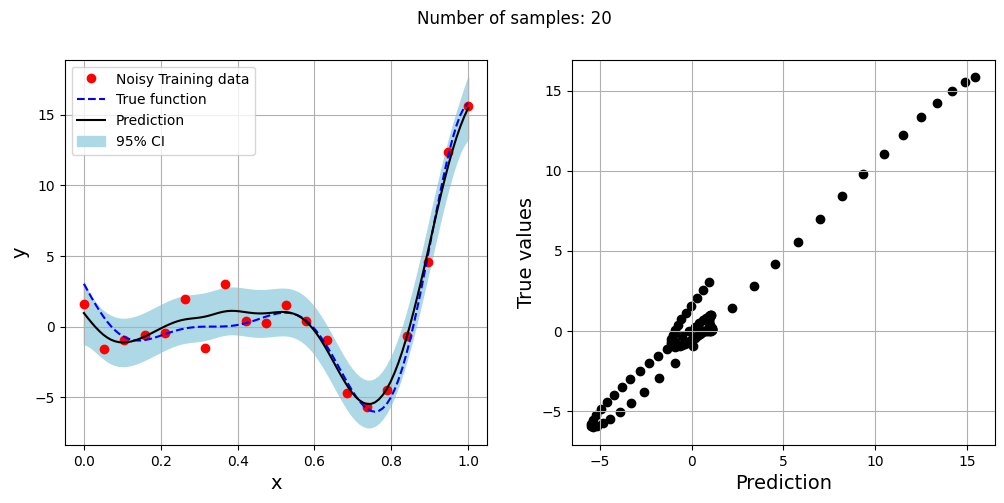

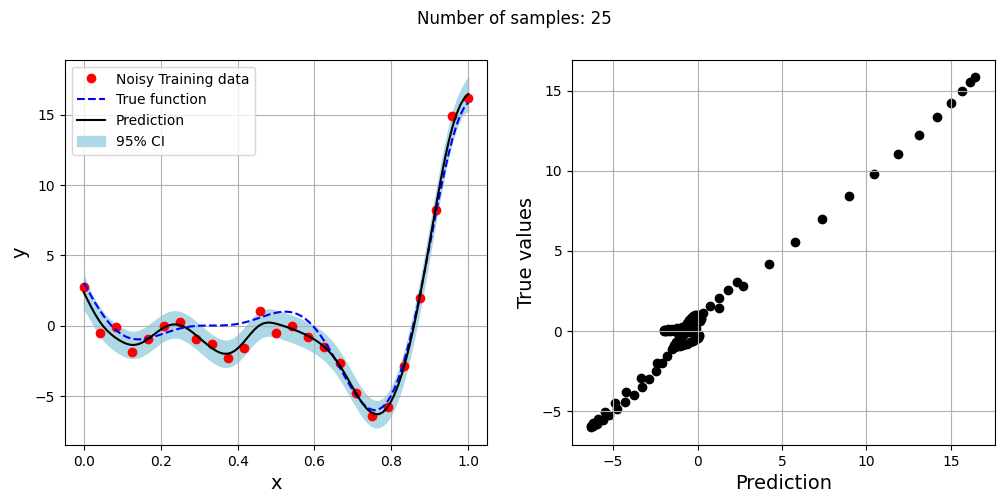

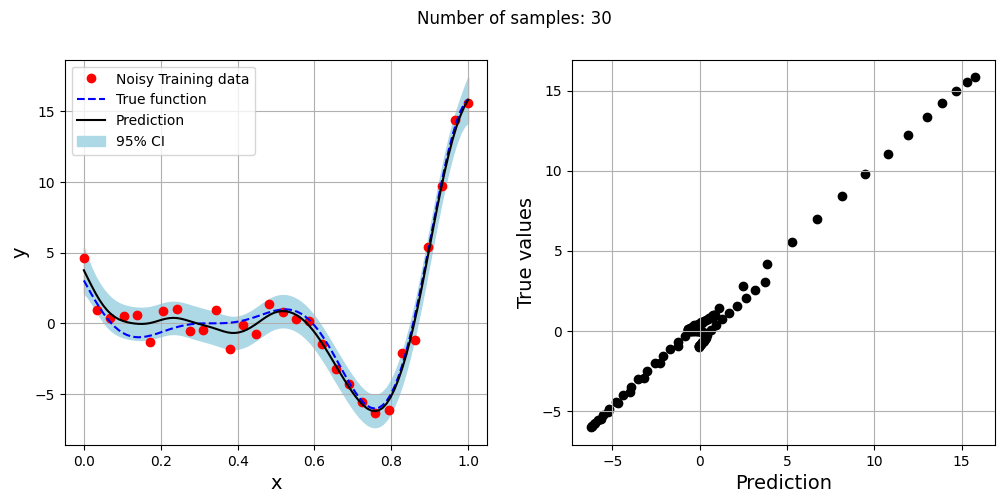

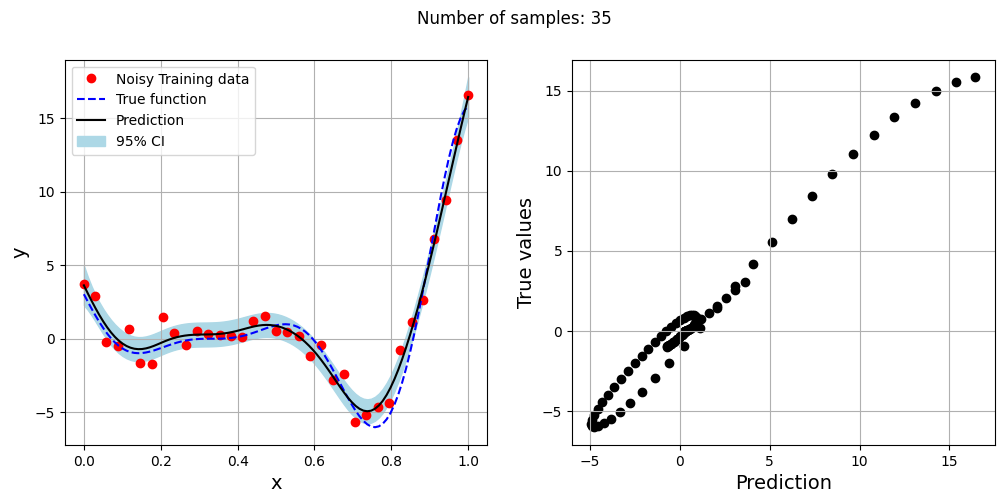

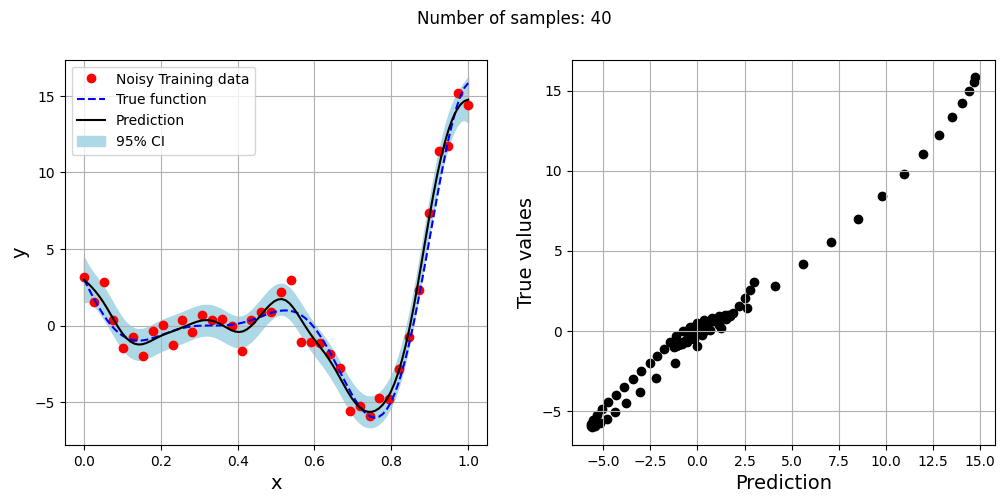

In [3]:
# Plotting data
xplot = np.linspace(0, 1, 100)
yplot = (6*xplot-2)**2 * np.sin(12*xplot-4)

# Creating array of training sample sizes
samples = np.array([5,15,20,25,30,35,40])

# Initializing nrmse list
nrmse = []

# Fitting with different sample size
for sample in samples:
    
    xtrain = np.linspace(0, 1, sample)
    ytrain = forrester(xtrain)
    
    # Fitting the kriging
    sm = KRG(theta0=[1e-2], corr='matern52', theta_bounds=[1e-6, 1e2], print_global=False, eval_noise = True)
    sm.set_training_values(xtrain, ytrain)
    sm.train()
    
    # Predict at test values
    yplot_pred = sm.predict_values(xplot).reshape(-1,)
    yplot_var = sm.predict_variances(xplot).reshape(-1,)

    # Calculating average nrmse
    nrmse.append(np.sqrt(mean_squared_error(yplot, yplot_pred)) / np.ptp(yplot))
    
    # Plotting prediction
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    
    ax[0].plot(xtrain, ytrain, 'ro', label='Noisy Training data')
    ax[0].plot(xplot, yplot, 'b--', label='True function')
    ax[0].plot(xplot, yplot_pred, 'k', label='Prediction')
    ax[0].fill_between(xplot, yplot_pred - 2*np.sqrt(yplot_var), yplot_pred + 2*np.sqrt(yplot_var), color='lightblue', label='95% CI')
    ax[0].set_xlabel("x", fontsize=14)
    ax[0].set_ylabel("y", fontsize=14)
    ax[0].grid()
    ax[0].legend()
    
    ax[1].scatter(yplot_pred, yplot, c="k")
    ax[1].set_xlabel("Prediction", fontsize=14)
    ax[1].set_ylabel("True values", fontsize=14)
    ax[1].grid()
    
    fig.suptitle("Number of samples: {}".format(sample))

## Exploitation of noisy Forrester function

The next blocks of code perform sequential sampling of the noisy Forrester function using exploitation. The regression Kriging model shown previously is used to create the model of the noisy function. This demonstrates finding the minimum of a noisy function that could be encountered in engineering scenarios. 

The next block of code defines the Problem class and optimization algorithm for `pymoo`. 

In [4]:
# Problem class
class Exploitation(Problem):

    def __init__(self, sm):
        super().__init__(n_var=1, n_obj=1, n_constr=0, xl=np.array([0]), xu=np.array([1]))

        self.sm = sm # store the surrogate model

    def _evaluate(self, x, out, *args, **kwargs):

        out["F"] = self.sm.predict_values(x)

# Optimization algorithm
algorithm = DE(pop_size=100, CR=0.8, dither="vector")

The following block of code performs the sequential sampling of the noisy Forrester function using exploitation. The initial sampling plan has 5 samples generated that are linearly spaced in the design range. The maximum iterations are set to 20 and the tolerance of the algorithm is set to $10^{-3}$. The regression Kriging model is used as the surrogate for the noisy Forrester function.

In [5]:
# Training data
num_train = 5
xtrain = np.linspace(0,1,num_train)
ytrain = forrester(xtrain)

# Variables
itr = 0
max_itr = 20
tol = 1e-3
delta_f = [1]
corr = 'squar_exp'
fs = 12

# Sequential sampling Loop
while itr < max_itr and tol < delta_f[-1]:
    
    print("\nIteration {}".format(itr + 1))

    # Initializing the kriging model
    sm = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False, eval_noise = True)

    # Setting the training values
    sm.set_training_values(xtrain, ytrain)
    
    # Creating surrogate model
    sm.train()

    # Find the minimum of surrogate model
    result = minimize(Exploitation(sm), algorithm, verbose=False)
    
    # Computing true function value at infill point
    y_infill = forrester(result.X.reshape(1,-1))

    if itr == 0:
        delta_f = [np.abs(result.F - y_infill)/np.abs(result.F)]
    else:
        delta_f = np.append(delta_f, np.abs(result.F - y_infill)/np.abs(result.F))
    
    print("Change in f: {}".format(delta_f[-1]))
    print("f*: {}".format(y_infill))
    print("x*: {}".format(result.X))
    
    # Appending the the new point to the current data set
    xtrain = np.append(xtrain, result.X.reshape(1,-1))
    ytrain = np.append( ytrain, y_infill )
    
    itr = itr + 1 # Increasing the iteration number

# Printing the final results
print("\nBest obtained point:")
print("x*: {}".format(xtrain[np.argmin(ytrain)]))
print("f*: {}".format(np.min(ytrain)))



Iteration 1
Change in f: [[0.03057438]]
f*: [[-6.37943267]]
x*: [0.75]

Iteration 2
Change in f: 0.0658586339620523
f*: [[-6.97523368]]
x*: [0.75]

Iteration 3
Change in f: 0.02153290398662742
f*: [[-6.54189728]]
x*: [0.74999994]

Iteration 4
Change in f: 0.01759926517809217
f*: [[-6.76812825]]
x*: [0.75000041]

Iteration 5
Change in f: 0.19200230738319096
f*: [[-5.39341386]]
x*: [0.75000443]

Iteration 6
Change in f: 0.024088413461245056
f*: [[-6.60813471]]
x*: [0.74992689]

Iteration 7
Change in f: 0.1123329128244355
f*: [[-7.20404397]]
x*: [0.74972857]

Iteration 8
Change in f: 0.16302201959017956
f*: [[-5.51962057]]
x*: [0.74690746]

Iteration 9
Change in f: 0.36527018984914666
f*: [[-4.80012902]]
x*: [0.76011309]

Iteration 10
Change in f: 0.1594448846833556
f*: [[-5.53833287]]
x*: [0.7518286]

Iteration 11
Change in f: 0.1496011981938855
f*: [[-7.32135706]]
x*: [0.74921961]

Iteration 12
Change in f: 0.22721089770552338
f*: [[-5.0921604]]
x*: [0.74535829]

Iteration 13
Change in

The exploitation algorithm is able to efficiently find the minimum of the Forrester function despite the noise in the function values. It can find the optimum $x^*$ value within a few iterations, however, the $f^*$ values are different due to the noise in the function. The noisy behaviour of the function can also prevent the exploitation algorithm from converging since convergence is based on changes in the function value. 

The block of code below plots the true function, predicted function, initial samples and infill samples. 

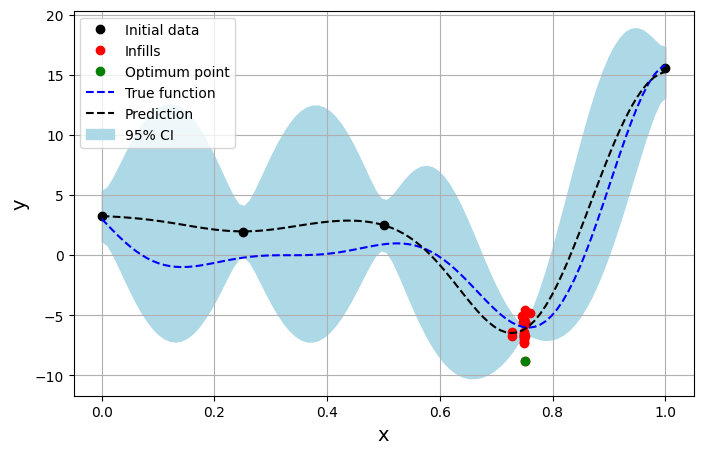

In [6]:
# Predict at test values
yplot_pred = sm.predict_values(xplot).reshape(-1,)
yplot_var = sm.predict_variances(xplot).reshape(-1,)

# Plotting prediction and infill points
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.plot(xtrain[:num_train], ytrain[:num_train], 'ko', label='Initial data')
ax.plot(xtrain[num_train:], ytrain[num_train:], 'ro', label='Infills')
ax.plot(xtrain[np.argmin(ytrain)], np.min(ytrain), 'go', label = 'Optimum point')
ax.plot(xplot, yplot, 'b--', label='True function')
ax.plot(xplot, yplot_pred, 'k--', label='Prediction')
ax.fill_between(xplot, yplot_pred - 2*np.sqrt(yplot_var), yplot_pred + 2*np.sqrt(yplot_var), color='lightblue', label='95% CI')
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("y", fontsize=14)
ax.grid()
ax.legend()

## Data Scaling for engineering modeling

While working with data obtained in engineering work, the design variables or features of the data may have vastly different magnitudes. For example, when working with data from engineering structures, stress-related quantities could be on the order of $10^6$ Pa while the dimensions of the structure could be on the order of $10^{-3}$ m. The design variables in this case vary by several orders of magnitude. Due to the large variation in the orders of magnitude in the data, it can be hard to use it to create a surrogate model directly. Typically, it is hard to train the models when the design variables can vary by several orders of magnitude. To make it easier to create surrogate models in such situations, scaling is applied to the design variables to bring each design variable to the same order of magnitude or within the same range of values. 

To demonstrate the use of scaling, the [Torsion Vibration](https://smt.readthedocs.io/en/latest/_src_docs/problems/torsionvibration.html) function will be used. It is a 15-dimensional function with the values of design variables varying from the order of $10^7$ to $10^{-2}$. The function is high-dimensional and the design variables have a large variation in order of magnitude. Radial basis function (RBF) models will be used to model the [Torsion Vibration](https://smt.readthedocs.io/en/latest/_src_docs/problems/torsionvibration.html) problem. Normalization and Standardization scaling will be applied to the data of the function and the NRMSE of the prediction of the model will be calculated for different numbers of training samples. 

The block of code below defines the [Torsion Vibration](https://smt.readthedocs.io/en/latest/_src_docs/problems/torsionvibration.html) function implemented in SMT. 

In [7]:
# Defining the Torsion Vibration problem
ndim = 15
problem = TorsionVibration(ndim=ndim)

Since RBF models are used for this section, a function is defined to find the best $\sigma$ for the RBF model for given training and testing data. This function is similar to the one seen earlier in the Jupyter book with the addition of two arguments providing the scaling methods for the input and output data.

In [8]:
def find_sigma(x_train, y_train, x_test, y_test, sigmas, x_scaler = None, y_scaler = None):
    """
    This function finds the best sigma for a RBF model by fitting the model to the training data and
    evaluating it on testing data. The best sigma is the one that achieves minimum normalized RMSE.

    Parameters
    ----------
    x_train : numpy array
        Training data x values
    y_train : numpy array
        Training data y values
    x_test : numpy array
        Testing data x values
    y_test : numpy array
        Testing data y values
    sigmas : numpy array
        Sigmas to be tested
    x_scaler: sklearn scaler object for x_train
    y_scler: sklearn scaler object for y_train

    Returns
    -------
    best_sigma : float
        Best sigma value
    metric : list
        List of NRMSE values for each sigma
    """

    # Initializing normalized RMSE list
    metric = []

    # Fitting various polynomials
    for sigma in sigmas:

        # Fit the RBF to current fold
        sm = RBF(d0=sigma, poly_degree=-1, print_global=False)
        sm.set_training_values(x_train, y_train)
        sm.train()

        # Predict at test values
        if x_scaler is not None and y_scaler is not None:
            y_pred = sm.predict_values(x_scaler.transform(x_test))
            y_pred = y_scaler.inverse_transform(y_pred)
        else:
            y_pred = sm.predict_values(x_test)

        # Adding all the rmse to calculate average later
        nrmse = np.sqrt(mean_squared_error(y_test, y_pred)) / np.ptp(y_test)
            
        # Calculating average nrmse
        metric.append(nrmse)

    best_sigma = sigmas[np.argmin(metric)]

    return best_sigma, metric

## Normalization Scaling

Normalization scales all of the design variables to a specified range using the minimum and maximum values of the variables in the data. The first step of normalization is to scale the variables to a range of $[0,1]$ using the minimum and maximum values. This scaling can be obtained as

$$X_{std} = \frac{X-X_{min}}{X_{max}-X_{min}}$$

where $X$ is the input/output data for the model and $X_{min}$ and $X_{max}$ are the minimum and maximum values of the input/output features. If the desired range for the data is $[0,1]$, then no further steps are required. However, if the desired range for the data is $[\min, \max]$, then $X_{std}$ must be further scaled to the required range

$$X_{scaled}=X_{std}(\text{max} - \text{min}) + \text{min}$$

The block of code below uses the MinMaxScaler from `sklearn` to normalize the data obtained for the Torsion Vibration function. An RBF model is fit to both the scaled and unscaled data for different numbers of training samples. Predictions are made on the testing data for the function and the NRMSE values are calculated for the predictions. 

In [9]:
# Creating testing data for the problem
test_sampler = FullFactorial(xlimits=problem.xlimits)
num_test = 100
xtest = test_sampler(num_test)
ytest = problem(xtest)

# Standard scaling
xmm_scaler = MinMaxScaler()
ymm_scaler = MinMaxScaler()

# Fitting with different sample size
train_sampler = LHS(xlimits=problem.xlimits, criterion="ese")

# Defining the number of samples
samples = [5,10,15,20,25,30,35,40,45,50]

scaled_nrmse = []
nrmse = []

for sample in samples:
    # Creating a model with and without scaling
    num = sample
    xtrain = train_sampler(num)
    ytrain = problem(xtrain)
    
    xtrain_scaled = xmm_scaler.fit_transform(xtrain)
    ytrain_scaled = ymm_scaler.fit_transform(ytrain)
    
    sigmas = np.logspace(-15, 15, 1000)
    best_sigma, test_metric = find_sigma(xtrain, ytrain, xtest, ytest, sigmas, x_scaler=None, y_scaler=None)
    best_sigma_scaled, test_metric_scaled = find_sigma(xtrain_scaled, ytrain_scaled, xtest, ytest, sigmas, xmm_scaler, ymm_scaler)
    
    # Fitting RBF using scaled data
    sm_scaled = RBF(d0=best_sigma_scaled, print_global = False)
    sm_scaled.set_training_values(xtrain_scaled, ytrain_scaled)
    sm_scaled.train()
    
    # Fitting RBF using unscaled data
    sm = RBF(d0=best_sigma, print_global = False)
    sm.set_training_values(xtrain, ytrain)
    sm.train()
    
    # Predicting on test data
    ypred_scaled = sm_scaled.predict_values(xmm_scaler.transform(xtest))
    ypred_scaled = ymm_scaler.inverse_transform(ypred_scaled)
    ypred = sm.predict_values(xtest)

    scaled_nrmse.append(np.sqrt(mean_squared_error(ytest, ypred_scaled)) / np.ptp(ytest))
    nrmse.append(np.sqrt(mean_squared_error(ytest, ypred)) / np.ptp(ytest))

The next block of code will plot the NRMSE values against the number of training samples for both the scaled and unscaled data.

Text(0, 0.5, 'Normalized RMSE')

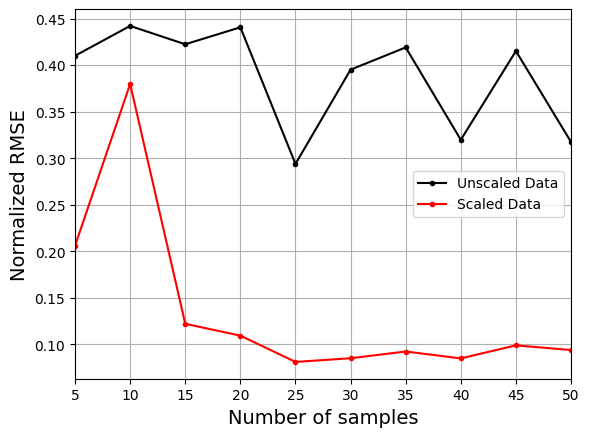

In [10]:
# Plotting NMRSE
fig, ax = plt.subplots()
ax.plot(samples, np.array(nrmse), c="k", marker=".", label = "Unscaled Data")
ax.plot(samples, np.array(scaled_nrmse), c="r", marker=".", label = "Scaled Data")
ax.grid(which="both")
ax.legend()
ax.set_xlim((samples[0], samples[-1]))
ax.set_xlabel("Number of samples", fontsize=14)
ax.set_ylabel("Normalized RMSE", fontsize=14)

The plot above shows that using the scaled data to create the model consistently leads to lower NRMSE values than the model created using the unscaled data. It is difficult to train the model using the unscaled data and there is little improvement in the NRMSE values as the number of samples increases.

## Standardization Scaling

Standardization scales the data to be of mean 0 and standard deviation 1. The first step of the scaling is to calculate the mean ($\mu$) and standard deviation ($\sigma$) of each feature in the input or output data. Once the $\mu$ and $\sigma$ are calculated, the data can be scaled as 

$$X_{scaled} = \frac{X-\mu}{\sigma}$$

The block of code below uses the StandardScaler from `sklearn` to normalize the data obtained for the Torsion Vibration function. An RBF model is fit to both the scaled and unscaled data for different numbers of training samples. Predictions are made on the testing data for the function and the NRMSE values are calculated for the predictions. 

In [11]:
# Creating testing data for the problem
test_sampler = FullFactorial(xlimits=problem.xlimits)
num_test = 100
xtest = test_sampler(num_test)
ytest = problem(xtest)

# Standard scaling
xstd_scaler = StandardScaler()
ystd_scaler = StandardScaler()

# Fitting with different sample size
train_sampler = LHS(xlimits=problem.xlimits, criterion="ese")

# Defining the number of samples
samples = [5,10,15,20,25,30,35,40,45,50]

scaled_nrmse = []
nrmse = []

for sample in samples:
    # Creating a model with and without scaling
    num = sample
    xtrain = train_sampler(num)
    ytrain = problem(xtrain)
    
    xtrain_scaled = xstd_scaler.fit_transform(xtrain)
    ytrain_scaled = ystd_scaler.fit_transform(ytrain)
    
    sigmas = np.logspace(-15, 15, 1000)
    best_sigma, test_metric = find_sigma(xtrain, ytrain, xtest, ytest, sigmas, x_scaler=None, y_scaler=None)
    best_sigma_scaled, test_metric_scaled = find_sigma(xtrain_scaled, ytrain_scaled, xtest, ytest, sigmas, xstd_scaler, ystd_scaler)
    
    # Fitting RBF using scaled data
    sm_scaled = RBF(d0=best_sigma_scaled, print_global = False)
    sm_scaled.set_training_values(xtrain_scaled, ytrain_scaled)
    sm_scaled.train()
    
    # Fitting RBF using unscaled data
    sm = RBF(d0=best_sigma, print_global = False)
    sm.set_training_values(xtrain, ytrain)
    sm.train()
    
    # Predicting on test data
    ypred_scaled = sm_scaled.predict_values(xstd_scaler.transform(xtest))
    ypred_scaled = ystd_scaler.inverse_transform(ypred_scaled)
    ypred = sm.predict_values(xtest)

    scaled_nrmse.append(np.sqrt(mean_squared_error(ytest, ypred_scaled)) / np.ptp(ytest))
    nrmse.append(np.sqrt(mean_squared_error(ytest, ypred)) / np.ptp(ytest))

The next block of code will plot the NRMSE values against the number of training samples for both the scaled and unscaled data.

Text(0, 0.5, 'Normalized RMSE')

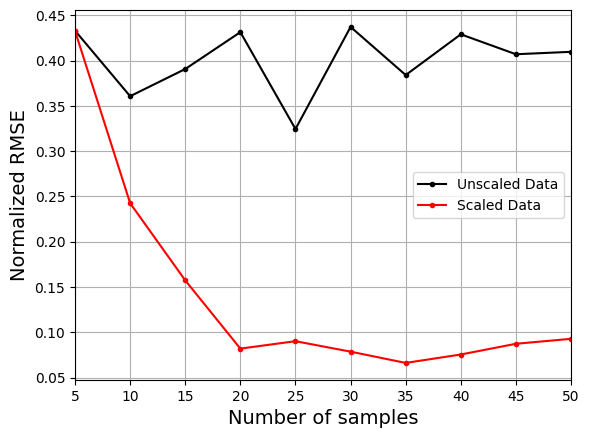

In [12]:
# Plotting NMRSE
fig, ax = plt.subplots()
ax.plot(samples, np.array(nrmse), c="k", marker=".", label = "Unscaled Data")
ax.plot(samples, np.array(scaled_nrmse), c="r", marker=".", label = "Scaled Data")
ax.grid(which="both")
ax.legend()
ax.set_xlim((samples[0], samples[-1]))
ax.set_xlabel("Number of samples", fontsize=14)
ax.set_ylabel("Normalized RMSE", fontsize=14)

Similar to normalization, the plot above shows that using the scaled data to create the model consistently leads to lower NRMSE values than the model created using the unscaled data. It is difficult to train the model using the unscaled data and there is little improvement in the NRMSE values as the number of samples increases.